This code simulates the reshuffle CA and prints the state after every step.


In [1]:
! pip install pygame

In [2]:

import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
import random

import pygame
import numpy as np
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
os.environ["SDL_VIDEODRIVER"] = "dummy"

# Take one Step

In [4]:
class State:
    def __init__(self, field_size, prey_population, predator_population, prey_death_rate, predator_death_rate, prey_birth_rate, predator_birth_rate):
        self.field_size = field_size
        self.prey_population = prey_population
        self.predator_population = predator_population
        self.field = self.init_field(field_size, prey_population, predator_population)
        self._prey_death_rate = prey_death_rate
        self._predator_death_rate = predator_death_rate
        self._prey_birth_rate = prey_birth_rate
        self._predator_birth_rate = predator_birth_rate

    def init_field(self, field_size, prey_population, predator_population):
        field = np.zeros((field_size, field_size))

        prey_location = np.random.choice(field_size*field_size, prey_population, replace=False)
        predator_location = np.random.choice(np.setdiff1d(np.arange(field_size*field_size), prey_location), predator_population, replace=False)

        prey_index = np.unravel_index(prey_location, (field_size, field_size))
        predator_index = np.unravel_index(predator_location, (field_size, field_size))

        field[prey_index] = 1
        field[predator_index] = 2

        return field

    def take_step(self):
        interactions = 0
        newField = np.array(self.field)

        for (x, y), element in np.ndenumerate(self.field):
            if element == 1:
                r = np.random.uniform(0, 1)
                predators_in_neighboorhood = self.count_target_moore(x,y,2)
                if predators_in_neighboorhood != 0:
                    interactions += 1
                if not (r < (1-self._prey_death_rate)**predators_in_neighboorhood):
                    r = np.random.uniform(0, 1)
                    if r < self._predator_birth_rate:
                        newField[x,y] = 2
                        self.predator_population += 1
                        self.prey_population -= 1
                        #interactions +=1
            if element == 2:
                r = np.random.uniform(0, 1)
                if r < self._predator_death_rate:
                    newField[x,y] = 0
                    self.predator_population -= 1
            if element == 0:
                predators_in_neighboorhood = self.count_target_moore(x,y,2)
                preys_in_neighboorhood = self.count_target_moore(x,y,1)
                if preys_in_neighboorhood > 0 and predators_in_neighboorhood == 0:
                    r = np.random.uniform(0, 1)
                    if r < self._prey_birth_rate**preys_in_neighboorhood:
                        newField[x,y] = 1
                        self.prey_population += 1
        self.field = newField
        return interactions


    def count_target_moore(self, x, y, target):
        offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1),  (1, 0),  (1, 1)]
        count = 0

        for dr, dc in offsets:
            r_neighbor = x + dr
            c_neighbor = y + dc
            if r_neighbor >= self.field_size:
                r_neighbor = 0
            if r_neighbor < 0:
                r_neighbor = self.field_size - 1
            if c_neighbor >= self.field_size:
                c_neighbor = 0
            if c_neighbor < 0:
                c_neighbor = self.field_size - 1
            if self.field[r_neighbor, c_neighbor] == target:
                count += 1
        return count

# Simulation

In [5]:
# FIELD_SIZE = 25
# PREY_POPULATION = 100
# PREDATOR_POPULATION = 66
#FIELD_SIZE = 35
FIELD_SIZE = 25#25
PREY_POPULATION = 100
PREDATOR_POPULATION = 66
FIELD_HEIGHT = FIELD_SIZE
FIELD_WIDTH = FIELD_SIZE


# VISUALIZATION PARAMETERS
CELL_SIZE = 10 #Set the size of the grid block
WINDOW_HEIGHT = FIELD_HEIGHT * CELL_SIZE
WINDOW_WIDTH = FIELD_WIDTH * CELL_SIZE

In [6]:
BLACK = (0, 0, 0)
WHITE = (200, 200, 200)
RED = (255, 0, 0)
GREEN = (0, 255, 0)

def main(mode: str=None, **kwargs):
    global SCREEN, CLOCK
    prey_history = []
    predator_history = []
    interaction_history = []
    pygame.init()
    SCREEN = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    CLOCK = pygame.time.Clock()
    SCREEN.fill(BLACK)

    state = State(FIELD_SIZE,
                  PREY_POPULATION,
                  PREDATOR_POPULATION,
                  prey_death_rate=0.5, #beta
                  predator_death_rate=0.3, #gamma
                  prey_birth_rate=0.7, #alpha
                  predator_birth_rate=0.5) #delta

    #state = State(FIELD_SIZE,
    #              100,
    #              20,
    #              prey_death_rate=0.03,
    #              predator_death_rate=0.1,
    #              prey_birth_rate=0.15,
    #              predator_birth_rate=0.01)

    #drawState(state, 0)
    prey_history.append(state.prey_population)
    predator_history.append(state.predator_population)
    if mode == 'ONE-STEP':
        simulate_one_step(state, prey_history, predator_history, interaction_history)
    elif mode == 'WHILE':
        while True:
            simulate_one_step(state, prey_history, predator_history, interaction_history)
    elif mode == 'FOR':
        step_n = kwargs.get('step_n', 10)
        for i in range(step_n):
            simulate_one_step(state, prey_history, predator_history, interaction_history, i+1)

    return prey_history, predator_history, interaction_history

def simulate_one_step(state, prey_history, predator_history, interaction_history, step_n):
    # SOMEWHERE HERE SHOULD BE UPDATE STATE
    interaction_history.append((state.take_step())/(prey_history[-1] * predator_history[-1]))
    prey_history.append(state.prey_population)
    predator_history.append(state.predator_population)
    state.field = state.init_field(state.field_size, state.prey_population, state.predator_population)
    #print(state.field)
    drawState(state, step_n)
    pygame.display.update()


def drawState(state, step_n):
    # for x in range(0, WINDOW_WIDTH, CELL_SIZE):
    #     for y in range(0, WINDOW_HEIGHT, CELL_SIZE):
    for i in range(0, FIELD_WIDTH):
        x = i * CELL_SIZE
        for j in range(0, FIELD_HEIGHT):
          y = j * CELL_SIZE
          rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)

          # iterate by indexing
          if state.field[i][j] == 0:
              # just black cell, left as black screen
              pygame.draw.rect(SCREEN, BLACK, rect)
          elif state.field[i][j] == 1:
              # draw predator
              pygame.draw.rect(SCREEN, GREEN, rect)
          elif state.field[i][j] == 2:
              # draw prey
              pygame.draw.rect(SCREEN, RED, rect)
          else:
              raise Exception
              print('something wrong with state, some cell are not in {0, 1, 2}')

          # Draw white rectangle for the borders
          pygame.draw.rect(SCREEN, WHITE, rect, 1)


    pygame.display.flip()

    view = pygame.surfarray.array3d(SCREEN)

    #  convert from (width, height, channel) to (height, width, channel)
    view = view.transpose([1, 0, 2])

    #  convert from rgb to bgr
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'reshuffle/{step_n}.jpg', img_bgr)


    #Display image, clear cell every 0.5 seconds
    cv2_imshow(img_bgr)
    time.sleep(0.5)
    output.clear()

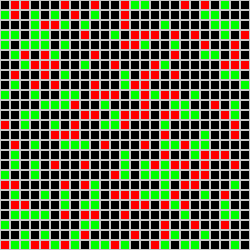

KeyboardInterrupt: 

In [7]:
prey_history, predator_history, interaction_history = main('FOR', step_n=200)

# Visualization

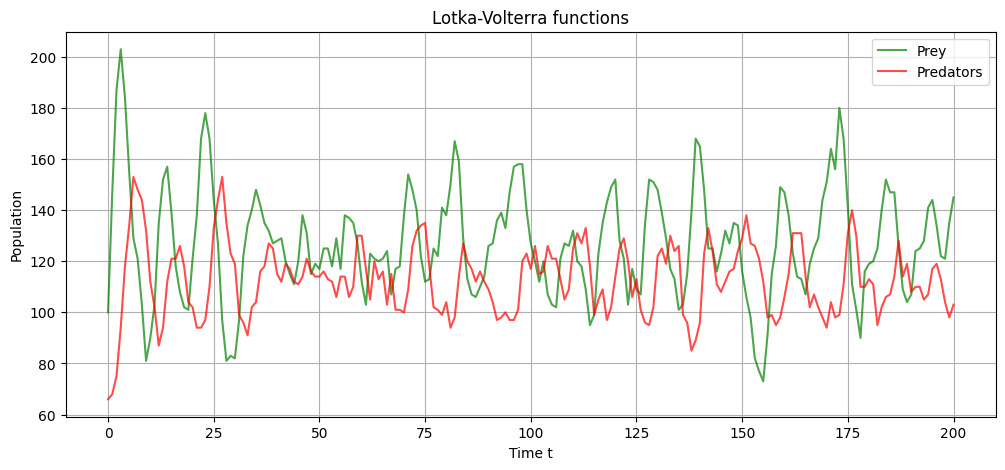

In [ ]:
plt.figure(figsize=(12,5))
plt.grid()
plt.title("Lotka-Volterra functions")
plt.plot(prey_history, 'g', label = 'Prey', alpha = 0.7)
plt.plot(predator_history, 'r', label = "Predators", alpha=0.7)
plt.xlabel('Time t')
plt.ylabel('Population')
plt.legend()
plt.show()

# Sandbox (not used Code)

In [ ]:
FIELD_SIZE = 3
#FIELD_SIZE = 35
FIELD_HEIGHT = FIELD_SIZE
FIELD_WIDTH = FIELD_SIZE
PREY_POPULATION = 5
PREDATOR_POPULATION = 2

CELL_SIZE = 10 #Set the size of the grid block
WINDOW_HEIGHT = FIELD_HEIGHT * CELL_SIZE
WINDOW_WIDTH = FIELD_WIDTH * CELL_SIZE
state = State(FIELD_SIZE,
                  5,
                  2,
                  prey_death_rate=0.6,
                  predator_death_rate=0.3,
                  prey_birth_rate=0.7,
                  predator_birth_rate=0.6)
print(state.field_size)

global SCREEN, CLOCK
prey_history = []
predator_history = []
interaction_history = []
pygame.init()
SCREEN = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
CLOCK = pygame.time.Clock()
SCREEN.fill(BLACK)
drawState(state)

3
test
test
test
test
test
test
test
test
test


In [ ]:
state.take_step()

1

In [ ]:
drawState(state)

test
test
test
test
test
test
test
test
test


In [ ]:
state.field = state.init_field(state.field_size, state.prey_population, state.predator_population)

In [ ]:
drawState(state)

test
test
test
test
test
test
test
test
test


In [ ]:
state.take_step()

3

In [ ]:
drawState(state)

test
test
test
test
test
test
test
test
test
